In [1]:
from google.colab import drive
drive.mount('/content/drive')
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow 1.x selected.
1.15.2


In [2]:
import pandas as pd
import numpy as np
import datetime
import time
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
import math
import random

# read data from csv file and process X, y
def data_loader(data_path):
		# load raw data
		df = pd.read_csv(data_path)

		# clean data with missing values          
		'''drop the rows directly -> mess up the order
			first 24 rows have pm2.5 value that is NaN -> discard
			else: forward filling'''
		df = df[24:].fillna(method='ffill')

		# integrate 'year', 'month', 'day', 'hour', 'No' as one attribute
		df['time'] = df.apply(lambda x : datetime.datetime(year=x['year'], month=x['month'], day=x['day'], hour=x['hour']), axis=1)
		df.drop(columns=['year', 'month', 'day', 'hour', 'No'], inplace=True)
		df = df.set_index('time')

		# expand "cbwd" into 4 attributes 'SE', 'cv', 'NW', 'NE'
		df = df.join(pd.get_dummies(df['cbwd'])) # one-hot encoding
		del df['cbwd']

		# df = df.drop('cbwd', axis = 1) # remove the attribute temporarily

		X = df.iloc[:,1:].astype(np.float32)
		y = df['pm2.5'].astype(np.float32).to_frame()
	
		return X, y
  
# Z-score normalisation
def data_normalisation(train, test):
		X_train, y_train = train[0], train[1]
		X_test, y_test = test[0], test[1]

		mean_x, std_x = X_train.mean(axis=0), X_train.std(axis=0)
		mean_y, std_y = y_train.mean(axis=0), y_train.std(axis=0)
	
		# Use the mean & std of train. Since there's no way for us to know the future.
		# (X_train, y_train) = ((X_train-mean_x)/std_x, (y_train-mean_y)/std_y)
		# (X_val, y_val) = ((X_val-mean_x)/std_x, (y_val-mean_y)/std_y) 
		# (X_test, y_test) = ((X_test-mean_x)/std_x, (y_test-mean_y)/std_y)
		(X_train, y_train) = ((X_train-mean_x)/std_x, np.log(np.asarray(y_train) + 1))
		(X_test, y_test) = ((X_test-mean_x)/std_x, np.log(np.asarray(y_test) + 1))
		# (X_train, y_train) = ((X_train-mean_x)/std_x, y_train)
		# (X_val, y_val) = ((X_val-mean_x)/std_x, y_val) 
		# (X_test, y_test) = ((X_test-mean_x)/std_x, y_test)

		return (X_train, y_train),(X_test, y_test)

data_path = "/content/drive/My Drive/Colab Notebooks/PM2dot5.csv"
X, y = data_loader(data_path)

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, shuffle=True)

(X_train, y_train),(X_test, y_test) = data_normalisation((X_train, y_train),(X_test, y_test))

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((35040, 10), (35040, 1), (8760, 10), (8760, 1))

In [3]:
#Network parameters
n_input = 10 
n_hidden1, n_hidden2 = 20, 10
n_output = 1
#Learning parameters 
#learning_rate = 0.00005
number_epochs = 3000
#batch_size = 128

#Defining the input and the output
X_p = tf.placeholder("float", [None, n_input], name='X_p') 
Y_p = tf.placeholder("float", [None, n_output], name='Y_p')

# forward
def multilayer_perceptron(input_d):
    #DEFINING WEIGHTS AND BIASES
    b1 = tf.Variable(tf.random_normal([n_hidden1])) #Biases first hidden layer
    b2 = tf.Variable(tf.random_normal([n_hidden2])) #Biases second hidden layer
    # b3 = tf.Variable(tf.random_normal([n_hidden3])) #Biases third hidden layer
    # b4 = tf.Variable(tf.random_normal([n_output]))  #Biases output layer
    b3 = tf.Variable(tf.random_normal([n_output]))  #Biases output layer
    
    w1 = tf.Variable(tf.random_normal([n_input, n_hidden1]))   #Weights connecting input layer with first hidden layer
    w2 = tf.Variable(tf.random_normal([n_hidden1, n_hidden2])) #Weights connecting first hidden layer with second hidden layer 
    # w3 = tf.Variable(tf.random_normal([n_hidden2, n_hidden3])) #Weights connecting second hidden layer with third layer
    # w4 = tf.Variable(tf.random_normal([n_hidden3, n_output]))  #Weights connecting third hidden layer with output layer
    w3 = tf.Variable(tf.random_normal([n_hidden2, n_output]))

    layer_1 = tf.nn.leaky_relu(tf.add(tf.matmul(input_d, w1), b1), alpha=0.01) #Task of neurons of first hidden layer
    layer_2 = tf.nn.leaky_relu(tf.add(tf.matmul(layer_1, w2), b2), alpha=0.01) #Task of neurons of second hidden layer
    # layer_3 = tf.nn.relu(tf.add(tf.matmul(layer_2, w3), b3)) #Task of neurons of thrid layer
    out_layer = tf.add(tf.matmul(layer_2, w3),b3)            #Task of neurons of output layer
    
    return out_layer

# create model
neural_network = multilayer_perceptron(X_p)
# define loss function
loss_func = tf.reduce_mean(tf.math.squared_difference(neural_network,Y_p)) # MSE
eval_RMSE = tf.cast(tf.sqrt(loss_func),dtype=tf.float32)
# define optimizer
#optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_func)

# initializaing variables
#init = tf.global_variables_initializer()

Fold 1, lr: 5e-05, batch_size: 64
Epoch: 1000, Training loss: 6.335039, Validation loss: 6.205028, 
Epoch: 2000, Training loss: 3.5719209, Validation loss: 3.4388802, 
Epoch: 3000, Training loss: 3.0207598, Validation loss: 2.4578927, 
The total training time is: 10.301231


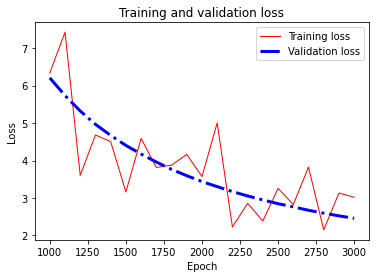

<Figure size 432x288 with 0 Axes>

Final Training loss: 3.0207598, Final Validation loss: 2.4578927, Training RMSE: 1.7380333, Validation RMSE: 1.5677668
-------------------------------------------------------------------------------------


Fold 2, lr: 5e-05, batch_size: 64
Epoch: 1000, Training loss: 6.47687, Validation loss: 6.2758055, 
Epoch: 2000, Training loss: 3.321235, Validation loss: 4.086252, 
Epoch: 3000, Training loss: 1.9941312, Validation loss: 3.0760336, 
The total training time is: 10.076354999999998


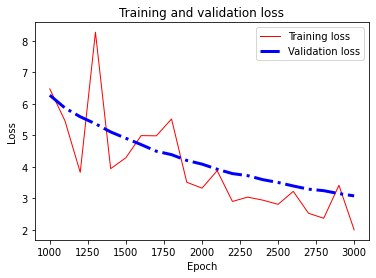

<Figure size 432x288 with 0 Axes>

Final Training loss: 1.9941312, Final Validation loss: 3.0760336, Training RMSE: 1.4121372, Validation RMSE: 1.7538625
-------------------------------------------------------------------------------------


Fold 3, lr: 5e-05, batch_size: 64
Epoch: 1000, Training loss: 7.4165535, Validation loss: 8.02864, 
Epoch: 2000, Training loss: 3.5932264, Validation loss: 5.624874, 
Epoch: 3000, Training loss: 3.6315787, Validation loss: 4.397478, 
The total training time is: 10.114772000000002


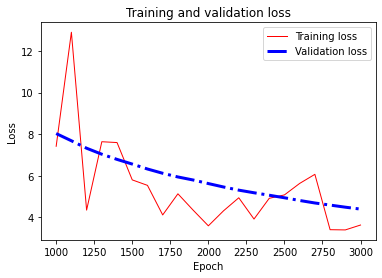

<Figure size 432x288 with 0 Axes>

Final Training loss: 3.6315787, Final Validation loss: 4.397478, Training RMSE: 1.9056702, Validation RMSE: 2.0970166
-------------------------------------------------------------------------------------


Fold 4, lr: 5e-05, batch_size: 64
Epoch: 1000, Training loss: 6.9958572, Validation loss: 9.59179, 
Epoch: 2000, Training loss: 4.092024, Validation loss: 5.936265, 
Epoch: 3000, Training loss: 3.9914637, Validation loss: 4.446783, 
The total training time is: 9.944794000000002


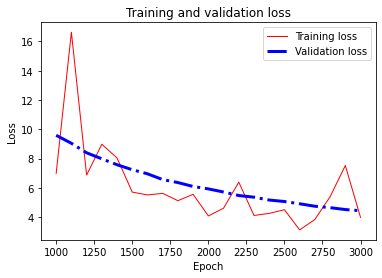

<Figure size 432x288 with 0 Axes>

Final Training loss: 3.9914637, Final Validation loss: 4.446783, Training RMSE: 1.9978647, Validation RMSE: 2.1087396
-------------------------------------------------------------------------------------


Fold 5, lr: 5e-05, batch_size: 64
Epoch: 1000, Training loss: 3.5378823, Validation loss: 3.8044233, 
Epoch: 2000, Training loss: 1.4849846, Validation loss: 2.0920148, 
Epoch: 3000, Training loss: 1.9278934, Validation loss: 1.6502546, 
The total training time is: 10.155139999999996


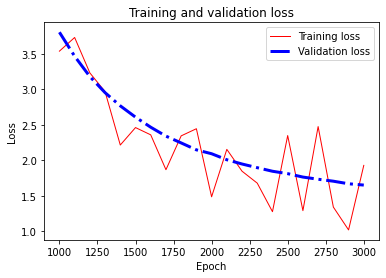

<Figure size 432x288 with 0 Axes>

Final Training loss: 1.9278934, Final Validation loss: 1.6502546, Training RMSE: 1.388486, Validation RMSE: 1.2846223
-------------------------------------------------------------------------------------


Fold 6, lr: 5e-05, batch_size: 64
Epoch: 1000, Training loss: 5.063614, Validation loss: 6.050677, 
Epoch: 2000, Training loss: 2.7049189, Validation loss: 4.018486, 
Epoch: 3000, Training loss: 3.658173, Validation loss: 3.1372187, 
The total training time is: 10.182689999999994


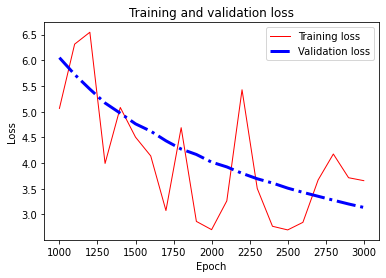

<Figure size 432x288 with 0 Axes>

Final Training loss: 3.658173, Final Validation loss: 3.1372187, Training RMSE: 1.9126351, Validation RMSE: 1.7712196
-------------------------------------------------------------------------------------


Fold 7, lr: 5e-05, batch_size: 64
Epoch: 1000, Training loss: 5.568836, Validation loss: 7.147897, 
Epoch: 2000, Training loss: 3.664495, Validation loss: 4.317271, 
Epoch: 3000, Training loss: 3.5691874, Validation loss: 3.2893963, 
The total training time is: 10.174373000000003


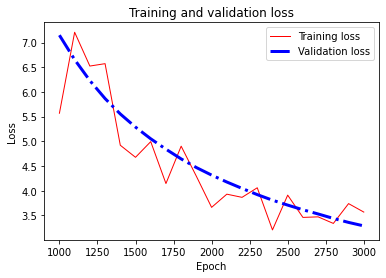

<Figure size 432x288 with 0 Axes>

Final Training loss: 3.5691874, Final Validation loss: 3.2893963, Training RMSE: 1.8892293, Validation RMSE: 1.8136693
-------------------------------------------------------------------------------------


Fold 8, lr: 5e-05, batch_size: 64
Epoch: 1000, Training loss: 6.4834466, Validation loss: 5.8814297, 
Epoch: 2000, Training loss: 3.6397746, Validation loss: 4.05386, 
Epoch: 3000, Training loss: 3.2120867, Validation loss: 3.1812932, 
The total training time is: 10.124688000000006


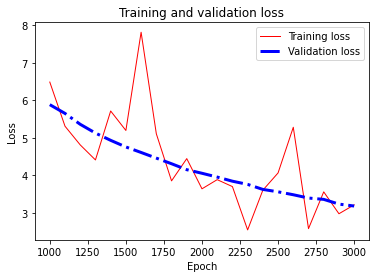

<Figure size 432x288 with 0 Axes>

Final Training loss: 3.2120867, Final Validation loss: 3.1812932, Training RMSE: 1.7922295, Validation RMSE: 1.783618
-------------------------------------------------------------------------------------


Fold 9, lr: 5e-05, batch_size: 64
Epoch: 1000, Training loss: 3.9953375, Validation loss: 3.9083295, 
Epoch: 2000, Training loss: 2.371107, Validation loss: 2.7680585, 
Epoch: 3000, Training loss: 2.6698916, Validation loss: 2.2155347, 
The total training time is: 10.189586000000006


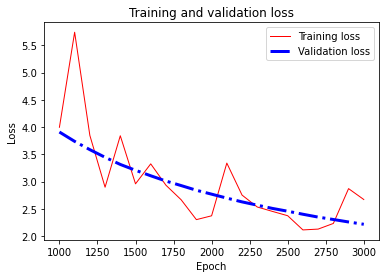

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.6698916, Final Validation loss: 2.2155347, Training RMSE: 1.6339803, Validation RMSE: 1.4884672
-------------------------------------------------------------------------------------


Fold 10, lr: 5e-05, batch_size: 64
Epoch: 1000, Training loss: 4.255492, Validation loss: 3.6529145, 
Epoch: 2000, Training loss: 1.8300531, Validation loss: 2.0847425, 
Epoch: 3000, Training loss: 1.7530805, Validation loss: 1.649071, 
The total training time is: 10.882020999999995


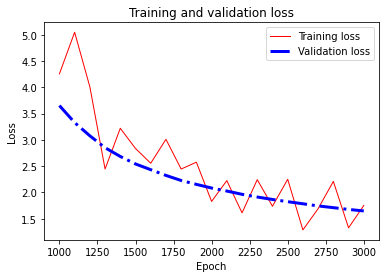

<Figure size 432x288 with 0 Axes>

Final Training loss: 1.7530805, Final Validation loss: 1.649071, Training RMSE: 1.3240395, Validation RMSE: 1.2841616
-------------------------------------------------------------------------------------


For the model with learning rate: 5e-05, batch size: 64 

Average Training RMSE for the 10 folds: 1.6994305 

Average Validation RMSE for the 10 folds: 1.6953144 


-------------------------------------------------------------------------------------


Fold 1, lr: 5e-05, batch_size: 128
Epoch: 1000, Training loss: 8.032286, Validation loss: 7.5169625, 
Epoch: 2000, Training loss: 5.4567475, Validation loss: 4.792882, 
Epoch: 3000, Training loss: 3.2670798, Validation loss: 3.5206096, 
The total training time is: 11.155990000000003


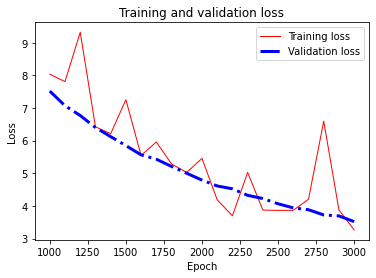

<Figure size 432x288 with 0 Axes>

Final Training loss: 3.2670798, Final Validation loss: 3.5206096, Training RMSE: 1.8075066, Validation RMSE: 1.8763287
-------------------------------------------------------------------------------------


Fold 2, lr: 5e-05, batch_size: 128
Epoch: 1000, Training loss: 4.4419165, Validation loss: 5.6912446, 
Epoch: 2000, Training loss: 4.706542, Validation loss: 3.4716127, 
Epoch: 3000, Training loss: 2.1834135, Validation loss: 2.629229, 
The total training time is: 10.667421000000004


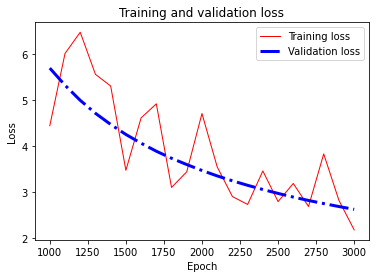

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.1834135, Final Validation loss: 2.629229, Training RMSE: 1.4776378, Validation RMSE: 1.6214898
-------------------------------------------------------------------------------------


Fold 3, lr: 5e-05, batch_size: 128
Epoch: 1000, Training loss: 4.1364536, Validation loss: 4.5515027, 
Epoch: 2000, Training loss: 2.4019814, Validation loss: 2.8399124, 
Epoch: 3000, Training loss: 2.5894327, Validation loss: 2.3246703, 
The total training time is: 10.405557000000016


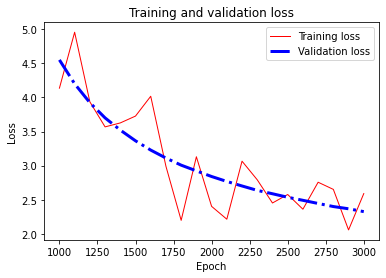

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.5894327, Final Validation loss: 2.3246703, Training RMSE: 1.6091714, Validation RMSE: 1.5246869
-------------------------------------------------------------------------------------


Fold 4, lr: 5e-05, batch_size: 128
Epoch: 1000, Training loss: 9.177422, Validation loss: 7.461351, 
Epoch: 2000, Training loss: 3.6126487, Validation loss: 4.500387, 
Epoch: 3000, Training loss: 3.5549498, Validation loss: 3.718622, 
The total training time is: 10.41990899999999


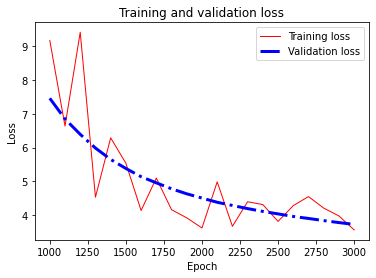

<Figure size 432x288 with 0 Axes>

Final Training loss: 3.5549498, Final Validation loss: 3.718622, Training RMSE: 1.8854574, Validation RMSE: 1.9283729
-------------------------------------------------------------------------------------


Fold 5, lr: 5e-05, batch_size: 128
Epoch: 1000, Training loss: 11.749988, Validation loss: 11.850221, 
Epoch: 2000, Training loss: 8.674403, Validation loss: 7.1074386, 
Epoch: 3000, Training loss: 5.4052496, Validation loss: 4.925922, 
The total training time is: 10.366770000000002


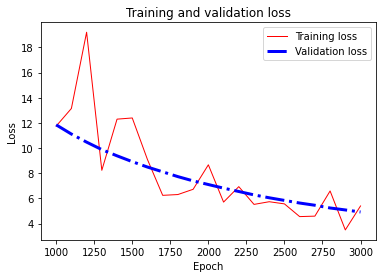

<Figure size 432x288 with 0 Axes>

Final Training loss: 5.4052496, Final Validation loss: 4.925922, Training RMSE: 2.3249192, Validation RMSE: 2.219442
-------------------------------------------------------------------------------------


Fold 6, lr: 5e-05, batch_size: 128
Epoch: 1000, Training loss: 4.7479296, Validation loss: 5.864236, 
Epoch: 2000, Training loss: 4.2062187, Validation loss: 3.4949355, 
Epoch: 3000, Training loss: 1.8591591, Validation loss: 2.5907922, 
The total training time is: 10.434933999999998


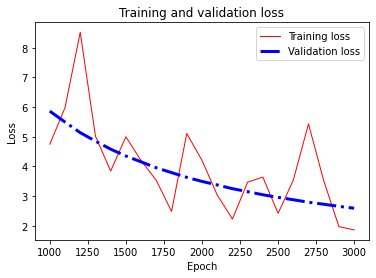

<Figure size 432x288 with 0 Axes>

Final Training loss: 1.8591591, Final Validation loss: 2.5907922, Training RMSE: 1.3635099, Validation RMSE: 1.6095937
-------------------------------------------------------------------------------------


Fold 7, lr: 5e-05, batch_size: 128
Epoch: 1000, Training loss: 8.032023, Validation loss: 7.5033894, 
Epoch: 2000, Training loss: 4.715139, Validation loss: 4.5481834, 
Epoch: 3000, Training loss: 2.5761456, Validation loss: 3.3847823, 
The total training time is: 10.449573000000015


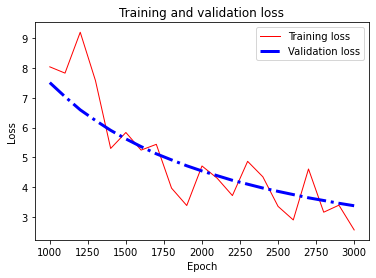

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.5761456, Final Validation loss: 3.3847823, Training RMSE: 1.6050376, Validation RMSE: 1.8397778
-------------------------------------------------------------------------------------


Fold 8, lr: 5e-05, batch_size: 128
Epoch: 1000, Training loss: 3.8781097, Validation loss: 3.4987297, 
Epoch: 2000, Training loss: 2.5308418, Validation loss: 2.631503, 
Epoch: 3000, Training loss: 2.0970476, Validation loss: 2.348862, 
The total training time is: 10.489053999999982


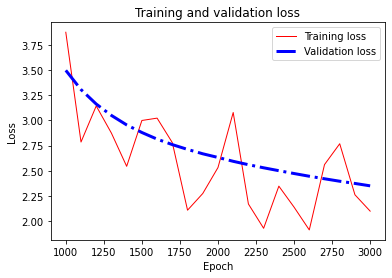

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.0970476, Final Validation loss: 2.348862, Training RMSE: 1.4481187, Validation RMSE: 1.5325997
-------------------------------------------------------------------------------------


Fold 9, lr: 5e-05, batch_size: 128
Epoch: 1000, Training loss: 3.703514, Validation loss: 4.076988, 
Epoch: 2000, Training loss: 3.5093617, Validation loss: 3.0427227, 
Epoch: 3000, Training loss: 1.9052083, Validation loss: 2.464026, 
The total training time is: 10.435421999999988


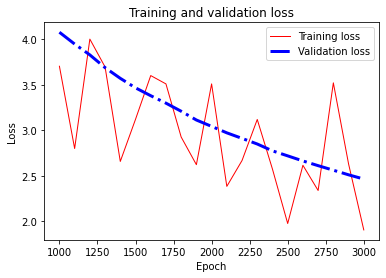

<Figure size 432x288 with 0 Axes>

Final Training loss: 1.9052083, Final Validation loss: 2.464026, Training RMSE: 1.3802929, Validation RMSE: 1.5697216
-------------------------------------------------------------------------------------


Fold 10, lr: 5e-05, batch_size: 128
Epoch: 1000, Training loss: 5.8654604, Validation loss: 6.8740706, 
Epoch: 2000, Training loss: 3.4753776, Validation loss: 3.3228931, 
Epoch: 3000, Training loss: 2.3582182, Validation loss: 2.1536343, 
The total training time is: 10.488861000000014


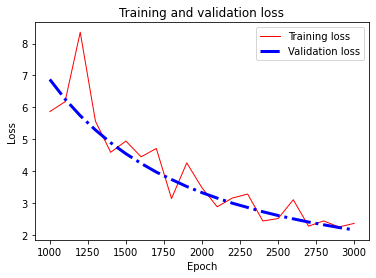

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.3582182, Final Validation loss: 2.1536343, Training RMSE: 1.5356491, Validation RMSE: 1.4675266
-------------------------------------------------------------------------------------


For the model with learning rate: 5e-05, batch size: 128 

Average Training RMSE for the 10 folds: 1.6715803 

Average Validation RMSE for the 10 folds: 1.707134 


-------------------------------------------------------------------------------------


Fold 1, lr: 0.0001, batch_size: 64
Epoch: 1000, Training loss: 4.407135, Validation loss: 4.5223827, 
Epoch: 2000, Training loss: 2.89368, Validation loss: 2.9487772, 
Epoch: 3000, Training loss: 2.5178008, Validation loss: 2.248499, 
The total training time is: 10.102520999999996


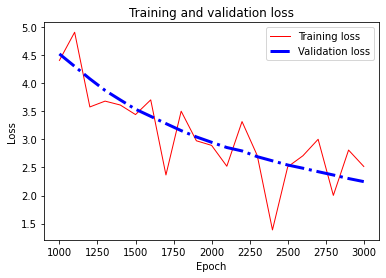

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.5178008, Final Validation loss: 2.248499, Training RMSE: 1.5867579, Validation RMSE: 1.4994996
-------------------------------------------------------------------------------------


Fold 2, lr: 0.0001, batch_size: 64
Epoch: 1000, Training loss: 4.327564, Validation loss: 3.7220206, 
Epoch: 2000, Training loss: 1.9760911, Validation loss: 2.0264578, 
Epoch: 3000, Training loss: 1.3778615, Validation loss: 1.5376866, 
The total training time is: 10.07065799999998


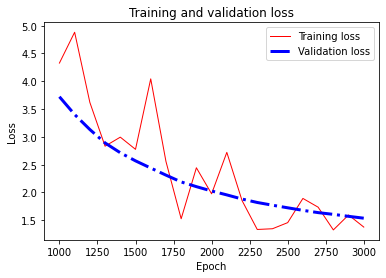

<Figure size 432x288 with 0 Axes>

Final Training loss: 1.3778615, Final Validation loss: 1.5376866, Training RMSE: 1.1738235, Validation RMSE: 1.2400349
-------------------------------------------------------------------------------------


Fold 3, lr: 0.0001, batch_size: 64
Epoch: 1000, Training loss: 5.4994097, Validation loss: 6.379553, 
Epoch: 2000, Training loss: 2.5445113, Validation loss: 3.1086457, 
Epoch: 3000, Training loss: 1.8152323, Validation loss: 1.8862412, 
The total training time is: 10.108222000000012


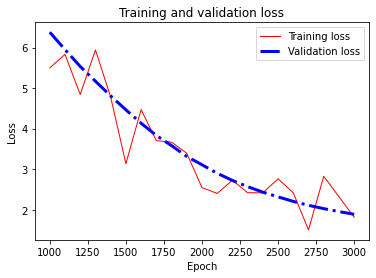

<Figure size 432x288 with 0 Axes>

Final Training loss: 1.8152323, Final Validation loss: 1.8862412, Training RMSE: 1.3473055, Validation RMSE: 1.373405
-------------------------------------------------------------------------------------


Fold 4, lr: 0.0001, batch_size: 64
Epoch: 1000, Training loss: 2.9586031, Validation loss: 2.9804342, 
Epoch: 2000, Training loss: 1.7902384, Validation loss: 2.088448, 
Epoch: 3000, Training loss: 1.9032793, Validation loss: 1.7630986, 
The total training time is: 10.016228999999981


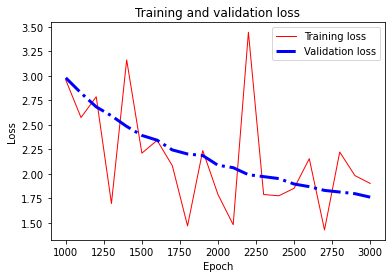

<Figure size 432x288 with 0 Axes>

Final Training loss: 1.9032793, Final Validation loss: 1.7630986, Training RMSE: 1.3795938, Validation RMSE: 1.3278172
-------------------------------------------------------------------------------------


Fold 5, lr: 0.0001, batch_size: 64
Epoch: 1000, Training loss: 2.588894, Validation loss: 2.6078174, 
Epoch: 2000, Training loss: 1.3349934, Validation loss: 1.6422061, 
Epoch: 3000, Training loss: 1.6384988, Validation loss: 1.3176166, 
The total training time is: 10.170072000000005


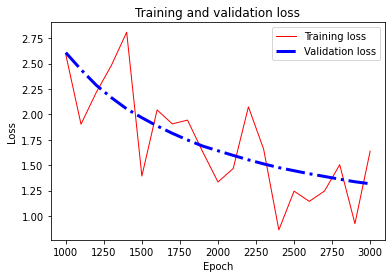

<Figure size 432x288 with 0 Axes>

Final Training loss: 1.6384988, Final Validation loss: 1.3176166, Training RMSE: 1.2800386, Validation RMSE: 1.1478748
-------------------------------------------------------------------------------------


Fold 6, lr: 0.0001, batch_size: 64
Epoch: 1000, Training loss: 6.0055404, Validation loss: 5.494942, 
Epoch: 2000, Training loss: 2.7480052, Validation loss: 3.1987138, 
Epoch: 3000, Training loss: 2.4457915, Validation loss: 2.2642865, 
The total training time is: 10.148954000000003


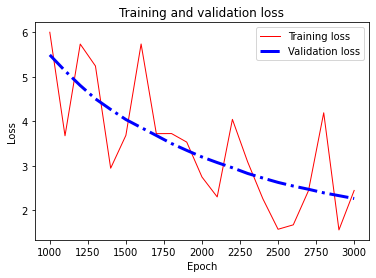

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.4457915, Final Validation loss: 2.2642865, Training RMSE: 1.5639026, Validation RMSE: 1.5047547
-------------------------------------------------------------------------------------


Fold 7, lr: 0.0001, batch_size: 64
Epoch: 1000, Training loss: 3.4831061, Validation loss: 3.6126826, 
Epoch: 2000, Training loss: 2.0413558, Validation loss: 2.3344772, 
Epoch: 3000, Training loss: 1.8434055, Validation loss: 1.8832551, 
The total training time is: 10.061740000000043


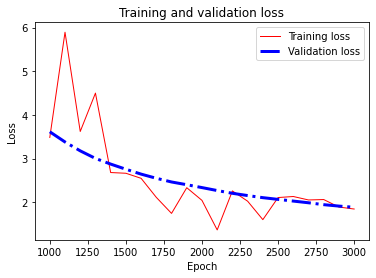

<Figure size 432x288 with 0 Axes>

Final Training loss: 1.8434055, Final Validation loss: 1.8832551, Training RMSE: 1.3577207, Validation RMSE: 1.3723174
-------------------------------------------------------------------------------------


Fold 8, lr: 0.0001, batch_size: 64
Epoch: 1000, Training loss: 4.2704244, Validation loss: 4.3967724, 
Epoch: 2000, Training loss: 2.5004013, Validation loss: 2.873456, 
Epoch: 3000, Training loss: 2.5998697, Validation loss: 2.2394216, 
The total training time is: 10.246302999999955


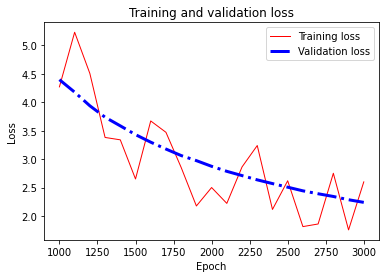

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.5998697, Final Validation loss: 2.2394216, Training RMSE: 1.6124111, Validation RMSE: 1.4964697
-------------------------------------------------------------------------------------


Fold 9, lr: 0.0001, batch_size: 64
Epoch: 1000, Training loss: 4.3169813, Validation loss: 6.864913, 
Epoch: 2000, Training loss: 3.7135599, Validation loss: 4.2769704, 
Epoch: 3000, Training loss: 2.86359, Validation loss: 3.0876236, 
The total training time is: 10.232639000000006


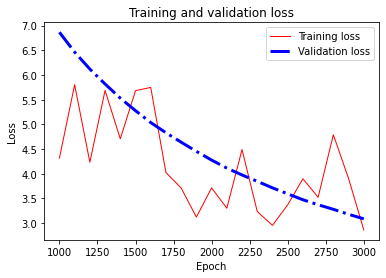

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.86359, Final Validation loss: 3.0876236, Training RMSE: 1.6922145, Validation RMSE: 1.7571635
-------------------------------------------------------------------------------------


Fold 10, lr: 0.0001, batch_size: 64
Epoch: 1000, Training loss: 2.8505034, Validation loss: 3.4872248, 
Epoch: 2000, Training loss: 2.2086866, Validation loss: 2.3110998, 
Epoch: 3000, Training loss: 2.2897625, Validation loss: 1.948334, 
The total training time is: 10.171817000000033


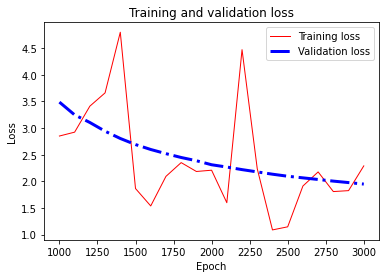

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.2897625, Final Validation loss: 1.948334, Training RMSE: 1.5131961, Validation RMSE: 1.3958273
-------------------------------------------------------------------------------------


For the model with learning rate: 0.0001, batch size: 64 

Average Training RMSE for the 10 folds: 1.5979522 

Average Validation RMSE for the 10 folds: 1.608595 


-------------------------------------------------------------------------------------


Fold 1, lr: 0.0001, batch_size: 128
Epoch: 1000, Training loss: 4.0286784, Validation loss: 3.7946672, 
Epoch: 2000, Training loss: 3.2947154, Validation loss: 2.4539387, 
Epoch: 3000, Training loss: 1.6847999, Validation loss: 1.9365411, 
The total training time is: 10.362664999999993


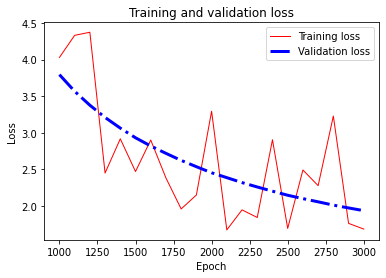

<Figure size 432x288 with 0 Axes>

Final Training loss: 1.6847999, Final Validation loss: 1.9365411, Training RMSE: 1.2979984, Validation RMSE: 1.3915966
-------------------------------------------------------------------------------------


Fold 2, lr: 0.0001, batch_size: 128
Epoch: 1000, Training loss: 4.724743, Validation loss: 5.028512, 
Epoch: 2000, Training loss: 2.6019511, Validation loss: 3.0638735, 
Epoch: 3000, Training loss: 2.1798897, Validation loss: 2.3142653, 
The total training time is: 10.480510000000038


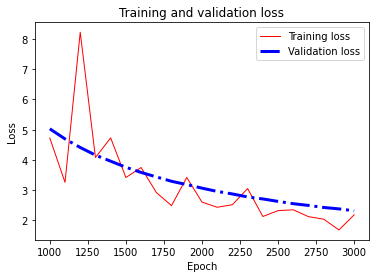

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.1798897, Final Validation loss: 2.3142653, Training RMSE: 1.476445, Validation RMSE: 1.521271
-------------------------------------------------------------------------------------


Fold 3, lr: 0.0001, batch_size: 128
Epoch: 1000, Training loss: 4.0702915, Validation loss: 3.817357, 
Epoch: 2000, Training loss: 2.7159374, Validation loss: 2.3600817, 
Epoch: 3000, Training loss: 1.7442291, Validation loss: 1.8256768, 
The total training time is: 10.417354999999986


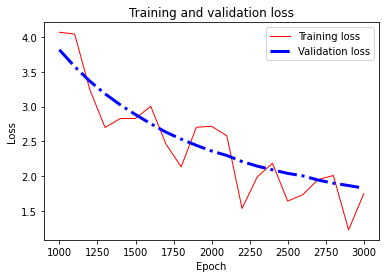

<Figure size 432x288 with 0 Axes>

Final Training loss: 1.7442291, Final Validation loss: 1.8256768, Training RMSE: 1.3206927, Validation RMSE: 1.351176
-------------------------------------------------------------------------------------


Fold 4, lr: 0.0001, batch_size: 128
Epoch: 1000, Training loss: 5.9610634, Validation loss: 5.453745, 
Epoch: 2000, Training loss: 3.7600815, Validation loss: 3.658512, 
Epoch: 3000, Training loss: 3.3028312, Validation loss: 2.9061174, 
The total training time is: 10.484066999999982


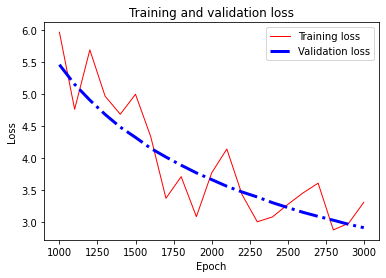

<Figure size 432x288 with 0 Axes>

Final Training loss: 3.3028312, Final Validation loss: 2.9061174, Training RMSE: 1.8173693, Validation RMSE: 1.7047338
-------------------------------------------------------------------------------------


Fold 5, lr: 0.0001, batch_size: 128
Epoch: 1000, Training loss: 4.3471375, Validation loss: 5.6190286, 
Epoch: 2000, Training loss: 3.8016014, Validation loss: 3.3518245, 
Epoch: 3000, Training loss: 3.4166899, Validation loss: 2.555454, 
The total training time is: 10.680549999999982


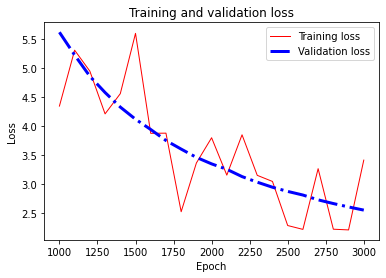

<Figure size 432x288 with 0 Axes>

Final Training loss: 3.4166899, Final Validation loss: 2.555454, Training RMSE: 1.8484291, Validation RMSE: 1.5985787
-------------------------------------------------------------------------------------


Fold 6, lr: 0.0001, batch_size: 128
Epoch: 1000, Training loss: 4.0959463, Validation loss: 4.120836, 
Epoch: 2000, Training loss: 2.3530564, Validation loss: 2.4790916, 
Epoch: 3000, Training loss: 1.8948822, Validation loss: 1.8084714, 
The total training time is: 10.62531100000001


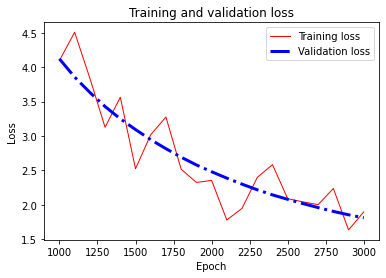

<Figure size 432x288 with 0 Axes>

Final Training loss: 1.8948822, Final Validation loss: 1.8084714, Training RMSE: 1.3765472, Validation RMSE: 1.3447942
-------------------------------------------------------------------------------------


Fold 7, lr: 0.0001, batch_size: 128
Epoch: 1000, Training loss: 3.9600115, Validation loss: 3.8295465, 
Epoch: 2000, Training loss: 2.6289058, Validation loss: 2.375841, 
Epoch: 3000, Training loss: 1.2340095, Validation loss: 1.7708122, 
The total training time is: 10.644244000000015


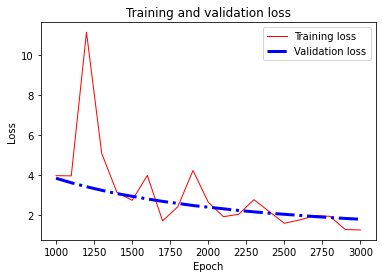

<Figure size 432x288 with 0 Axes>

Final Training loss: 1.2340095, Final Validation loss: 1.7708122, Training RMSE: 1.1108598, Validation RMSE: 1.3307186
-------------------------------------------------------------------------------------


Fold 8, lr: 0.0001, batch_size: 128
Epoch: 1000, Training loss: 3.975626, Validation loss: 4.455209, 
Epoch: 2000, Training loss: 2.8458807, Validation loss: 2.8829978, 
Epoch: 3000, Training loss: 2.518928, Validation loss: 2.3346975, 
The total training time is: 10.48566500000004


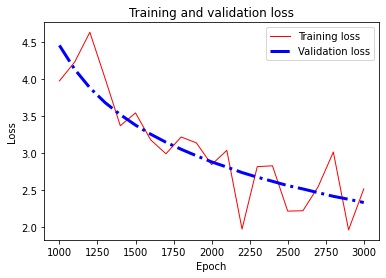

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.518928, Final Validation loss: 2.3346975, Training RMSE: 1.5871131, Validation RMSE: 1.5279717
-------------------------------------------------------------------------------------


Fold 9, lr: 0.0001, batch_size: 128
Epoch: 1000, Training loss: 3.6839104, Validation loss: 3.7495325, 
Epoch: 2000, Training loss: 4.504465, Validation loss: 2.322948, 
Epoch: 3000, Training loss: 2.4704084, Validation loss: 1.867948, 
The total training time is: 10.596434000000045


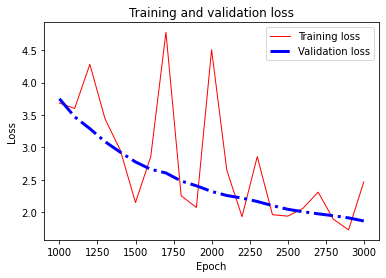

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.4704084, Final Validation loss: 1.867948, Training RMSE: 1.5717533, Validation RMSE: 1.366729
-------------------------------------------------------------------------------------


Fold 10, lr: 0.0001, batch_size: 128
Epoch: 1000, Training loss: 2.3595634, Validation loss: 2.5552287, 
Epoch: 2000, Training loss: 2.5921326, Validation loss: 1.7549124, 
Epoch: 3000, Training loss: 2.7282307, Validation loss: 1.4962527, 
The total training time is: 10.742243999999971


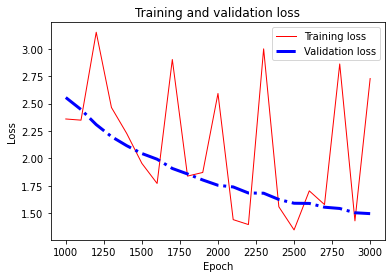

<Figure size 432x288 with 0 Axes>

Final Training loss: 2.7282307, Final Validation loss: 1.4962527, Training RMSE: 1.6517357, Validation RMSE: 1.223214
-------------------------------------------------------------------------------------


For the model with learning rate: 0.0001, batch size: 128 

Average Training RMSE for the 10 folds: 1.5749378 

Average Validation RMSE for the 10 folds: 1.5654657 


-------------------------------------------------------------------------------------


The best hyperparameters:

learning rate: 0.0001, batch size: 128



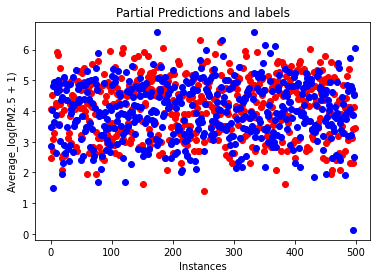

Average Test RMSE: 1.2576164


In [4]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)

train_x = []
test_x = []
train_y = []
test_y = []

select_epoch_from = 1000
batch_iteration = 0

train_loss = 0
val_loss = 0

# record the train losses for the total 10 fold models
kfold_train_losses = []
# record the validate losses for the total 10 fold models
kfold_val_losses = []

hyperParameters = {'lr':[0.00005,0.0001],'batch_size':[64,128]}

rmses = []
bset_lr = 0
best_batchsize = 0
best_training_rmse = 0
best_validation_rmse = 0

with tf.Session() as sess: 

    for lr in hyperParameters['lr']:

        for batch_size in hyperParameters['batch_size']:
            fold = 0
            for train_index, val_index in kf.split(X_train, y_train):
       
                # define optimizer
                optimizer = tf.train.GradientDescentOptimizer(lr).minimize(loss_func)
                # initializaing variables
                init = tf.global_variables_initializer()
                sess.run(init)
                start_time = time.clock() 
                fold = fold + 1

                train_x = X_train[train_index]
                train_y = y_train[train_index]
  
                val_x = X_train[val_index]
                val_y = y_train[val_index]
                
                batch_iteration = int(len(train_x) / batch_size) + 1
                
                print("Fold %s, lr: %s, batch_size: %s" % (fold,lr,batch_size))
                
                train_losses = []
                val_losses = []
                epochs = []
                for epoch in range(1,number_epochs+1):
          
                    n = epoch % batch_iteration
                    s = 0 + batch_size * n
                    if n == 0:
                       e = len(train_x)
                    else:
                       e = batch_size + batch_size * n
            
                    batch_X = np.array(X_train[s:e])
                    batch_y = np.array(y_train[s:e])

                    _, train_loss = sess.run([optimizer, loss_func], feed_dict={X_p: batch_X, Y_p: batch_y})
                    val_loss = loss_func.eval({X_p: val_x, Y_p: val_y})

                    if epoch >= select_epoch_from and epoch % 100 == 0:
                       train_losses.append(train_loss)
                       val_losses.append(val_loss)
                       epochs.append(epoch)

                    #Display the epoch
                    if epoch % 1000 == 0:
                       print("Epoch: %d, "
                             "Training loss: %s, "
                             "Validation loss: %s, " % (epoch, train_loss, val_loss))
                
                end_time = time.clock()
                print("The total training time is: " + str(end_time-start_time))

                pyplot.plot(epochs, train_losses, 'r', label='Training loss', linewidth=1, linestyle='-')
                pyplot.plot(epochs, val_losses, 'b', label='Validation loss', linewidth=3, linestyle='-.')
                pyplot.xlabel('Epoch') 
                pyplot.ylabel('Loss')
                pyplot.title('Training and validation loss')
                pyplot.legend()
                pyplot.figure()
                pyplot.show()
                pyplot.ioff()

                kfold_train_RMSE = np.sqrt(train_loss)
                kfold_val_RMSE = np.sqrt(val_loss)

                print("Final Training loss: %s, "
                      "Final Validation loss: %s, " 
                      "Training RMSE: %s, "
                      "Validation RMSE: %s"% (train_loss, val_loss, kfold_train_RMSE, kfold_val_RMSE )) 
                print("-------------------------------------------------------------------------------------\n\n")

                kfold_train_losses.append(kfold_train_RMSE)
                kfold_val_losses.append(kfold_val_RMSE)
  
                if fold == 10:
                   # average train RMSE for the 10 folds
                   average_train_rmse_score_10fold = np.mean(kfold_train_losses)
                   # average validate RMSE for the 10 folds
                   average_val_rmse_score_10fold = np.mean(kfold_val_losses)
                   print("For the model with learning rate: %s, batch size: %s \n" % (lr,batch_size))
                   print("Average Training RMSE for the 10 folds: %s \n" % str(average_train_rmse_score_10fold))
                   print("Average Validation RMSE for the 10 folds: %s \n\n" % str(average_val_rmse_score_10fold))
                   print("-------------------------------------------------------------------------------------\n\n")
                   if lr == 0.00005 and batch_size == 64:
                      #best_training_rmse = average_train_rmse_score_10fold
                      best_validation_rmse = average_val_rmse_score_10fold
                      best_lr = 0.00005
                      best_batchsize = 64
                   else: 
                      if average_val_rmse_score_10fold < best_validation_rmse:
                         #best_training_rmse = average_train_rmse_score_10fold
                         best_validation_rmse = average_val_rmse_score_10fold
                         best_lr = lr
                         best_batchsize = batch_size
                   #best_training_rmse.append(average_train_rmse_score_10fold)
                   #best_validation_rmse.append(average_val_rmse_score_10fold)
    print("The best hyperparameters:\n") 
    print("learning rate: %s, batch size: %s, RMSE: %s\n" % (best_lr,best_batchsize,best_validation_rmse))
    
    # Test model
    pred = (neural_network) 
    output=neural_network.eval({X_p: X_test}) 

    # plot prediction and labels
    pyplot.plot(y_test[0:500], 'ro', label='Testing labels')
    pyplot.plot(output[0:500], 'bo', label='Predictions')
    pyplot.xlabel('Instances') 
    pyplot.ylabel('Average_log(PM2.5 + 1)')
    pyplot.title('Partial Predictions and labels')
    pyplot.show()

    # final RMSE
    rmse_score = sess.run(eval_RMSE,feed_dict={X_p:X_test,Y_p:y_test})
    print("Average Test RMSE: " + str(rmse_score))
